# DFA and Factor Investing

## HBS Case
### *Dimensional Fund Advisors, 2002 [HBS 9-203-026].

*Pages 1-5 of the case are required. Pages 6-11 get into interesting issues around trading (especially adverse selection) and tax considerations. These sections are useful for building market knowledge, but we will not cover them.**

# 2. The Factors

DFA believes certain stocks have higher expected excess returns. In addition to the overall market equity premium, DFA believes that there is a premium attached to a **size** and **value** factor. Note that these three factors are already listed as **excess** returns.

### Data
Use the data found in `data/dfa_analysis_data.xlsx`.

- Monthly **excess** return data for the overall equity market, $\tilde{r}^{\text{mkt}}$. 

- The sheet also contains data on two additional factors, `SMB` and `HML`, as well as the risk-free rate. 

- You do not need any of these columns for the homework. Just use the `MKT` column, which is **excess** market returns. (So no need to subtract the risk-free rate.)

#### Source:

Ken French library, accessible through the pandas-datareader API.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import norm

#read data
factors = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="factors").drop('RF', axis=1)
factors.set_index('Date',inplace=True)
tot_ret = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="portfolios (total returns)")
tot_ret.set_index('Date',inplace=True)
factors.head(5)


,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0289,-0.0255,-0.0239
1926-08-31,0.0264,-0.0114,0.0381
1926-09-30,0.0038,-0.0136,0.0005
1926-10-31,-0.0327,-0.0014,0.0082
1926-11-30,0.0254,-0.0011,-0.0061


In [3]:
tot_ret.head(5)

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.058276,-0.017006,0.005118,-0.021477,0.019583,0.012118,0.024107,0.006056,-0.026082,-0.004527,...,0.015376,0.015460,0.013389,0.002765,0.024678,0.033248,0.060909,0.020285,0.031263,0.005623
1926-08-31,-0.020206,-0.080282,0.013968,0.021483,0.085104,0.023620,-0.007525,0.038984,0.002299,0.062937,...,0.013858,0.038587,0.019738,0.021336,0.053422,0.010169,0.041975,0.019769,0.054924,0.077576
1926-09-30,-0.048291,-0.026806,-0.043417,-0.032683,0.008586,-0.026849,-0.005252,0.010789,-0.032877,-0.009419,...,0.016897,-0.005246,-0.017724,0.014806,0.008730,-0.012951,0.036610,0.001384,-0.007497,-0.024284
1926-10-31,-0.093633,-0.035519,-0.035024,0.034413,-0.025452,-0.028014,-0.044191,-0.050767,-0.080271,-0.013213,...,-0.039136,-0.026528,-0.021058,-0.032532,-0.053525,-0.027382,-0.030061,-0.022467,-0.046725,-0.058129
1926-11-30,0.055888,0.041877,0.024384,-0.044495,0.005110,0.031023,-0.017317,0.030425,0.049538,0.027292,...,0.034492,0.023823,0.037315,0.051102,0.018213,0.044331,0.025355,0.015280,0.036596,0.025636


### 1. The Factors

Calculate their univariate performance statistics: 

* mean
* volatility
* Sharpe
* VaR(.05)

Report these for the following three subsamples:

* Beginning - 1980
* 1981 - 2001
* 2002 - End



In [4]:
#complete set-up
def performance_metrics(returns,annualization=1): #daily annualization = 252, monthly annualization = 12
    metrics = pd.DataFrame(index=returns.columns)
    metrics['Mean'] = returns.mean() * annualization
    metrics['Vol'] = returns.std() * np.sqrt(annualization)
    metrics['Sharpe'] = (returns.mean() / returns.std()) * np.sqrt(annualization)
    #skewness 
    metrics['Skewness'] = returns.skew()

    #kurtosis
    metrics['Kurtosis'] = returns.kurtosis() #excess kurtosis -3

    #VaR(.05)
    metrics['VaR(.05)'] = returns.quantile(0.05)

    #cVaR(.05)
    metrics['CVaR(.05)'] = returns[returns <= metrics['VaR(.05)']].mean()

    metrics['Min'] = returns.min()
    metrics['Max'] = returns.max()

    return metrics
#split factor data
factors_1980 = factors.loc[:"1980-12-31"]
factors_1981_2001 = factors.loc["1981-01-01":"2001-12-31"]
factors_2002_2025 = factors.loc["2002-01-01":]

In [ ]:

metrics_1980 = performance_metrics(factors_1980,12)
metrics_1981_2001 = performance_metrics(factors_1981_2001,12)
metrics_2002_2025 = performance_metrics(factors_2002_2025,12)

#table of the 3 dataframes by years
period_metrics = {
    '1926-1980': metrics_1980,
    '1981-2001': metrics_1981_2001,
    '2002-2025': metrics_2002_2025
}

metrics_combined = pd.concat(period_metrics, axis=0, keys=period_metrics.keys())
metrics_combined.drop(['Skewness','Kurtosis','CVaR(.05)','Min', 'Max'], axis=1).style.format("{:,.2%}")


### 2. 

Based on the factor statistics above, answer the following.

- Does each factor have a premium (positive expected excess return) in each subsample?

- Does the premium to the size factor get smaller after 1980?

- Does the premium to the value factor get smaller during the 1990's?

- How have the factors performed since the time of the case, (2002-present)?

- No, in the period of 1981-2001 the long small companies short large companies factor had a negative excess return.
- Yes, before 1981 small companies tending to outperform large companies by 3.39%. Whereas, beteween 1981 and 2001 the premium turned negative and between 2002-2025 the factor was only .79%.
- No, the value factor premium grew in the 90s. Over the 1981-2001 sample, the value factor grew to 6.46% annual outperformance over growth compared to 5.03% from 1926-1980.
-Today, the factor performance of small and value has shrunk considerable closer to zero. Specifically, .79% for small and .12% for value in recent years. This makes sense given the performance of growth indicies and concentration of gains among a few mega-cap firms in recent years.

### 3.

The factors are constructed in such a way as to reduce correlation between them.

* Report the correlation matrix across the three factors. 

* Does the construction method succeed in keeping correlations small? 

* Does it achieve this in each subsample?

In [6]:
#setup
def plot_correlation_matrix(rets):
    correlation_matrix = rets.corr()
    mask = np.triu(np.ones_like(correlation_matrix,dtype=bool))
    plt.figure(figsize=(8, 4)) # Set the figure size for better readability
    sns.heatmap(
        correlation_matrix,
        mask=mask,
        annot=True,
        fmt='.2f',
        cmap='coolwarm',
        vmin=-1,vmax=1,
        center=0,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8, "label": "Correlation"}
        )
    plt.title('Correlation Matrix')

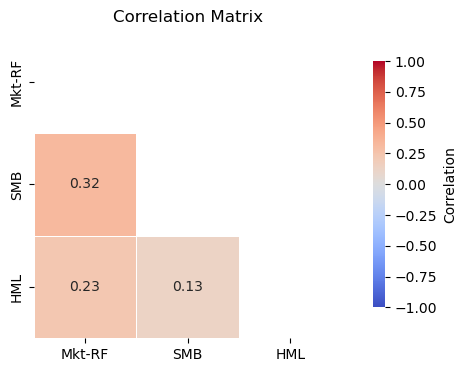

In [7]:
#TODO
plot_correlation_matrix(factors)

- The correlations between size and value are relatively small both being under .5. Their correlation with the market is also small, both being under .5.


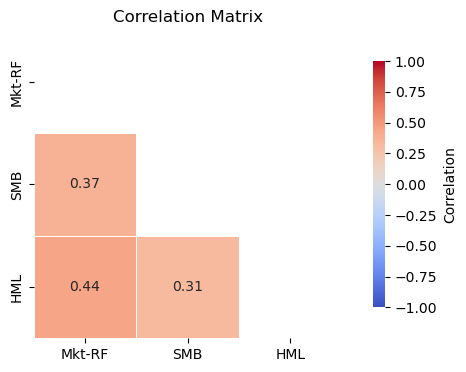

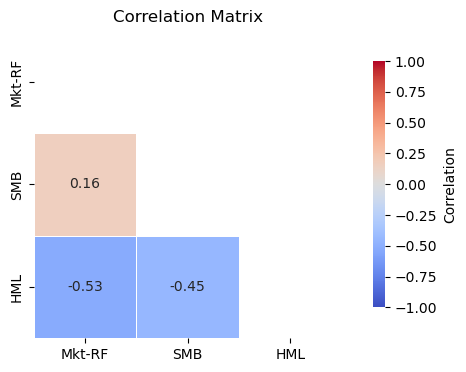

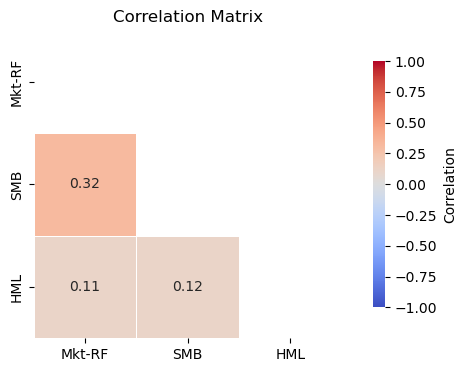

In [8]:
#feel free to make this prettier
#plot 3 correlation matrices side by side
plot_correlation_matrix(factors_1980)
plot_correlation_matrix(factors_1981_2001)
plot_correlation_matrix(factors_2002_2025)

- Within the subsamples the factors had differing levels of success at providing uncorrelated returns. Specifically, in the 1981-2001 subsample, the value factor had a relatively strong negative correlation with the market and size factor. Secondly, the other notable increase in correlation comparted to the full sample was in 1926-1980 where the value factor was almost twice as correlated with market returns than it was in the full sample. Overall, it is interesting that the correlation among the factors can have large swings within different windows of time.

### 4. 

* Plot the cumulative returns of the three factors. 

* Create plots for the 1981-2001 subsample as well as the 2002-Present subsample.

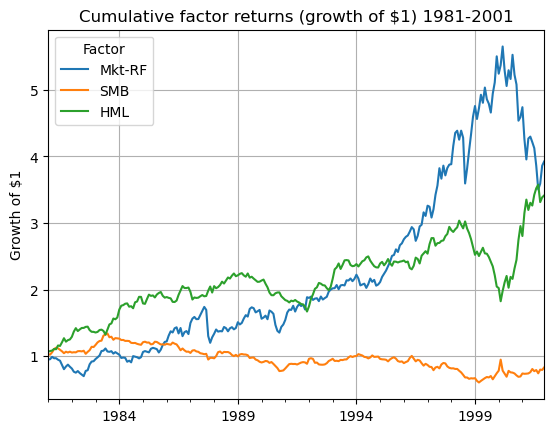

In [9]:
#TODO
factor_tot_ret_1981_2001 = (factors_1981_2001+1).cumprod()
factor_tot_ret_1981_2001.plot()
plt.title("Cumulative factor returns (growth of $1) 1981-2001")
plt.ylabel("Growth of $1")
plt.xlabel("")
plt.grid(True)
plt.legend(title="Factor")

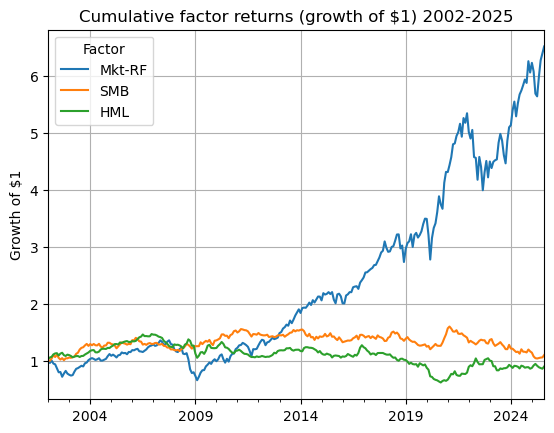

In [10]:
factor_tot_ret_2002_2025 = (factors_2002_2025+1).cumprod()
factor_tot_ret_2002_2025.plot()
plt.title("Cumulative factor returns (growth of $1) 2002-2025")
plt.ylabel("Growth of $1")
plt.xlabel("")
plt.grid(True)
plt.legend(title="Factor")

### 5.

* Does it appear that all three factors were valuable in 1981-2001? 
* And post-2001? 

Would you advise DFA to continue emphasizing all three factors?

- In 1981-2001, it appears that only the market and value factors were valuable
- Post 2001, only the market factor provided excess returns.

Based on these charts, I would not recommend DFA favor the small and value factors as they have had limited excess returns for the most recent sample.

# 3. CAPM

DFA believes that premia in stocks and stock portfolios is related to the three factors. 

Let's test `25` equity portfolios that span a wide range of size and value measures.

#### Footnote
For more on the portfolio construction, see the description at Ken French's data library. 
https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports.html

#### Portfolios
Monthly **total** return data on `25` equity portfolios sorted by their size-value characteristics. Denote these as $\vec{r}^{i}$, for $n=1, \ldots, 25$.
- Note that while the factors were given as excess returns, the portfolios are total returns.
- For this entire problem, focus on the 1981-Present subsample.

### 1. Summary Statistics. 

For each portfolio, 
- Use the Risk-Free rate column in the factors tab to convert these total returns to excess returns.
- Calculate the (annualized) univariate statistics from `1.1`.

In [11]:
#use rf to convert total returns to excess
risk_free = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="factors", index_col="Date")["RF"]
excess_ret = tot_ret.subtract(risk_free, axis=0)
excess_ret.head(5)

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056076,-0.019206,0.002918,-0.023677,0.017383,0.009918,0.021907,0.003856,-0.028282,-0.006727,...,0.013176,0.013260,0.011189,0.000565,0.022478,0.031048,0.058709,0.018085,0.029063,0.003423
1926-08-31,-0.022706,-0.082782,0.011468,0.018983,0.082604,0.021120,-0.010025,0.036484,-0.000201,0.060437,...,0.011358,0.036087,0.017238,0.018836,0.050922,0.007669,0.039475,0.017269,0.052424,0.075076
1926-09-30,-0.050591,-0.029106,-0.045717,-0.034983,0.006286,-0.029149,-0.007552,0.008489,-0.035177,-0.011719,...,0.014597,-0.007546,-0.020024,0.012506,0.006430,-0.015251,0.034310,-0.000916,-0.009797,-0.026584
1926-10-31,-0.096833,-0.038719,-0.038224,0.031213,-0.028652,-0.031214,-0.047391,-0.053967,-0.083471,-0.016413,...,-0.042336,-0.029728,-0.024258,-0.035732,-0.056725,-0.030582,-0.033261,-0.025667,-0.049925,-0.061329
1926-11-30,0.052788,0.038777,0.021284,-0.047595,0.002010,0.027923,-0.020417,0.027325,0.046438,0.024192,...,0.031392,0.020723,0.034215,0.048002,0.015113,0.041231,0.022255,0.012180,0.033496,0.022536


In [12]:
#calculate univariate stats
excess_metrics = performance_metrics(excess_ret, 12)
excess_metrics


,Mean,Vol,Sharpe,Skewness,Kurtosis,VaR(.05),CVaR(.05),Min,Max
SMALL LoBM,0.068285,0.412683,0.165465,3.105095,33.252191,-0.142903,-0.227614,-0.495030,1.478201
ME1 BM2,0.079138,0.334279,0.236743,2.934178,34.213427,-0.128362,-0.192479,-0.352972,1.260068
ME1 BM3,0.117213,0.306450,0.382487,2.129850,18.668438,-0.104112,-0.172320,-0.343065,0.828525
ME1 BM4,0.135062,0.286639,0.471192,2.736434,32.087050,-0.102063,-0.160264,-0.350082,1.048198
SMALL HiBM,0.160757,0.317360,0.506545,2.879209,28.413579,-0.113591,-0.172393,-0.330903,0.994873
ME2 BM1,0.077413,0.275990,0.280493,0.710057,8.948730,-0.111098,-0.171772,-0.330849,0.764562
ME2 BM2,0.110993,0.258963,0.428606,1.427627,17.065906,-0.096367,-0.154993,-0.325413,0.780988
ME2 BM3,0.115222,0.250012,0.460867,1.709714,19.514077,-0.092983,-0.149473,-0.352261,0.754724
ME2 BM4,0.124235,0.257403,0.482649,2.096466,22.971989,-0.093828,-0.151429,-0.314626,0.800670
ME2 BM5,0.147626,0.300293,0.491607,1.736505,18.042656,-0.112550,-0.179252,-0.379839,0.899424


### 2. CAPM

The Capital Asset Pricing Model (CAPM) asserts that an asset (or portfolio's) expected excess return is completely a function of its beta to the equity market index (`SPY`, or in this case, `MKT`.) 

Specifically, it asserts that, for any excess return, $\tilde{r}^{i}$, its mean is proportional to the mean excess return of the market, $\tilde{r}^{\text{mkt}}$, where the proporitonality is the regression beta of $\tilde{r}^{i}$ on $\tilde{r}^{\text{mkt}}$.

$$
\mathbb{E}\left[\tilde{r}_{t}^{i}\right] = \beta^{i,\text{mkt}}\; \mathbb{E}\left[\tilde{r}_{t}^{\text{mkt}}\right]
$$

Let's examine whether that seems plausible.

For each of the $n=25$ test portfolios, run the CAPM time-series regression:

$$
\tilde{r}_{t}^{i} = \alpha^i + \beta^{i,\text{mkt}}\; \tilde{r}_{t}^{\text{mkt}} + \epsilon_{t}^{i}
$$

So you are running 25 separate regressions, each using the $T$-sized sample of time-series data.

* Report the betas and alphas for each test asset.

* Report the mean-absolute-error of the CAPM:
$$\text{MAE} = \frac{1}{n}\sum_{i=1}^n \left|\alpha_i\right|$$

If the CAPM were true, what would we expect of the MAE?

- Report the estimated $\beta^{i,\text{mkt}}$, Treynor Ratio, $\alpha^i$, and Information Ratio for each of the $n$ regressions.

- If the CAPM model were true, what would be true of the Treynor Ratios, alphas, and Information Ratios?

In [13]:
#data for market excess returns
excess_market = pd.read_excel("data/dfa_analysis_data.xlsx", sheet_name="factors", index_col="Date")["Mkt-RF"]

#run CAPM regression on portfolios
results = {}
for port in excess_ret.columns:
    Y = excess_ret[port]
    X = sm.add_constant(excess_market)
    capm_model = sm.OLS(Y,X).fit()
    active_ret = Y - excess_market
    

    alpha = capm_model.params.iloc[0]
    beta = capm_model.params.iloc[1]
    r2 = capm_model.rsquared
    mae = np.mean(np.abs(capm_model.resid))
    trey = Y.mean() / beta
    info = (active_ret.mean() / active_ret.std()) * np.sqrt(12)

    results[port] = {
        "alpha": alpha,
        "beta": beta,
        "r2": r2,
        "mae": mae,
        "treynor": trey,
        "info": info 
    }

capm_results = pd.DataFrame(results).T
capm_results

,alpha,beta,r2,mae,treynor,info
SMALL LoBM,-0.005362,1.602311,0.511130,0.048178,0.003551,-0.046858
ME1 BM2,-0.003013,1.392971,0.588756,0.037669,0.004734,-0.016050
ME1 BM3,0.000392,1.359342,0.667127,0.033829,0.007186,0.182451
ME1 BM4,0.002532,1.264748,0.660097,0.030069,0.008899,0.300394
SMALL HiBM,0.004012,1.360529,0.623132,0.034442,0.009847,0.378901
ME2 BM1,-0.002310,1.270198,0.718171,0.029643,0.005079,-0.034618
ME2 BM2,0.000754,1.231694,0.767006,0.023892,0.007510,0.213686
ME2 BM3,0.001321,1.200621,0.781913,0.022086,0.007997,0.265007
ME2 BM4,0.001967,1.215841,0.756481,0.024027,0.008515,0.311549
ME2 BM5,0.002805,1.376946,0.712877,0.031263,0.008934,0.370099


- If the CAPM were true, we would expect MAE = 0 and alpha = 0 for each portfolio.
- Because CAPM predicts that the expected excess return of a portfolio is proportional to its beta, $$\text{Treynor} = \frac{\mathbb{E}[R_i - R_f]}{\beta^{i,m}} = \frac{\beta^{i,m}\cdot\mathbb{E}[R_m - R_f]}{\beta^{i,m}} = \mathbb{E}[R_m - R_f]$$ and all portfolios will have the same Treynor Ratio (market excess return).
- Finally, if CAPM is true, $$R_i - R_m = \text{resid. of CAPM reg.} = \alpha_i + \epsilon_i$$ and because alpha = 0 under CAPM, $$\mathbb{E}[R_i - R_m] = 0$$ and thus the Information Ratio would be 0 for each portfolio (this makes sense intuitively as, if CAPM holds, no portfolio can consistently outperform the market).


### 3. Cross-sectional Estimation

Let's test the CAPM directly. We already have what we need:

- The dependent variable, (y): mean excess returns from each of the $n=25$ portfolios.
- The regressor, (x): the market beta from each of the $n=25$ time-series regressions.

Then we can estimate the following equation:

$$
\underbrace{\mathbb{E}\left[\tilde{r}^{i}\right]}_{n\times 1\text{ data}} = \textcolor{ForestGreen}{\underbrace{\eta}_{\text{regression intercept}}} + \underbrace{{\beta}^{i,\text{mkt}};}_{n\times 1\text{ data}}~ \textcolor{ForestGreen}{\underbrace{\lambda_{\text{mkt}}}_{\text{regression estimate}}} + \textcolor{ForestGreen}{\underbrace{\upsilon}_{n\times 1\text{ residuals}}}
$$

Note that
- we use sample means as estimates of $\mathbb{E}\left[\tilde{r}^{i}\right]$. 
- this is a weird regression! The regressors are the betas from the time-series regressions we already ran!
- this is a single regression, where we are combining evidence across all $n=25$ series. Thus, it is a cross-sectional regression!
- the notation is trying to emphasize that the intercept is different than the time-series $\alpha$ and that the regressor coefficient is different than the time-series betas.

Report
- the R-squared of this regression.
- the intercept, $\eta$. 
- the regression coefficient, $\lambda_{\text{mkt}}$.

What would these three statistics be if the CAPM were completely accurate?

In [16]:
excess_mean = excess_ret.mean()
X = sm.add_constant(capm_results["beta"])
y = excess_mean
crosssec_model = sm.OLS(y, X).fit()

crossec_results = pd.Series({
    "eta": crosssec_model.params.iloc[0],
    "lambda": crosssec_model.params.iloc[1],
    "r2": crosssec_model.rsquared
}, name="Cross Section Regression")
crossec_results

eta       0.004004
lambda    0.003983
r2        0.097538
Name: Cross Section Regression, dtype: float64

- If CAPM were completely accurate, $$\eta = 0$$ $$\lambda_{mkt} = \mathbb{E}[R_m - R_f]$$ $$R^{2} = 1$$ because all portfolio mean excess returns would lie exactly on the CAPM line with no deviation.

### 4. Conclusion

Broadly speaking, do these results support DFA's belief in size and value portfolios containing premia unrelated to the market premium?

### 4. Conclusion

The cross-sectional CAPM regression produces an intercept (η) of **0.0040**, a slope (λ) of **0.0040**, and an \(R^2\) of **0.10**.  
Because both η and λ are in monthly excess return units, λ ≈ 0.004 implies a **market risk premium of roughly 0.4% per month** (~5% annualized).

While the estimated λ aligns with the market premium, the **low \(R^2\)** indicates that the market beta explains only about **10% of the variation** in average portfolio returns.  
The **non-zero intercept (η ≈ 0.004)** further suggests that some portfolios earn returns **not captured by market beta**, violating the pure CAPM prediction.

These results imply that the **single-factor CAPM does not fully explain** the cross-section of returns.  
The remaining variation likely reflects **additional systematic factors** such as **size (SMB)** and **value (HML)**, consistent with the multi-factor model advocated by DFA.

> **Conclusion Summary:**  
> - λ is consistent with the average market premium (plausible magnitude).  
> - η ≠ 0 and \(R^2\) ≪ 1 → CAPM is incomplete.  
> - Supports DFA’s belief that **size and value factors contain premia beyond the market**.
